In [14]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import pickle
from utils import * 

In [15]:
file_path = "data/trajectory.csv"
df = pd.read_csv(file_path, index_col=0)

with open('data/shared_variables.pkl', 'rb') as file_object:
    vars = pickle.load(file_object)

#Look in Datatransformation for order of variables
lower_spread_limit, upper_spread_limit, num_values = vars[0], vars[1], vars[2]

In [16]:
#We assume there is a upper and lower limit of pricespread. Dealers only use three decimals so I multiply by 1000. 
num_actions = int((upper_spread_limit-lower_spread_limit)*1000)
num_states = np.prod(num_values)

Q_table = np.zeros((num_states, num_actions), dtype=np.float32)

print(Q_table.shape)

(36864, 180)


In [17]:
#Alpha functions: Have to satisfy Robbins-Monro conditions
def alpha_1(N_t): #nt number of times action a is taken in given state 
    return 2/((N_t**(2/3))+1)

def alpha_2(t): #nt number of times action a is taken in given state 
    return 1/(t+1)


In [18]:
def QL(D, gamma, Q):
    '''
    Implementation of OPO Q-learning.

    :param data: Trajectory we want to learn from 
    :param gamma: Discount factor when using discounted MDPs
    :param alpha: Learning rate. Must fulfill the Robbins Monro conditions  
    '''
  
    #Make Q-table
    for t in range(len(D)-1):
        print(t)
        s, a, r, ns = int(D.iloc[t]['State_index']), int(D.iloc[t]['Action']), D.iloc[t]['Reward'], int(D.iloc[t]['Next_State'])
        alpha = alpha_2(t+1)
        max_next_Q = np.max(Q[ns, :]) if ns else 0
        delta_t = r + gamma * max_next_Q - Q[s, a]
        Q[s, a] += alpha * delta_t

    optimal_policy = np.argmax(Q, axis=1)
    return optimal_policy


def double_QL(D, gamma, QA, QB):
    """
    Implementation of Double Q-learning.

    Args:
        D (pd.DataFrame): Trajectory we want to learn from.
        gamma (float): Discount factor when using discounted MDPs.
        QA (np.ndarray): First Q-table.
        QB (np.ndarray): Second Q-table.

    Returns:
        np.ndarray: Optimal policy based on Double Q-learning.
    """
    for t in range(len(D) - 1):
        s, a, r, ns = int(D.iloc[t]['State_index']), int(D.iloc[t]['Action']), D.iloc[t]['Reward'], int(D.iloc[t]['Next_State'])
        alpha = alpha_2(t + 1)
        
        # Randomly choose which Q-table to update
        if np.random.rand() < 0.5:
            a_hat = np.argmax(QA[ns, :]) if ns else 0
            delta_t = r + gamma * QB[ns,a_hat] - QA[s, a]
            QA[s, a] += alpha * delta_t
        else:
            a_hat = np.argmax(QB[ns, :]) if ns else 0
            delta_t = r + gamma * QA[ns,a_hat] - QB[s, a]
            QB[s, a] += alpha * delta_t

    # Combine Q1 and Q2 to get the optimal policy
    optimal_policy = np.argmax(QA + QB, axis=1)
    return optimal_policy


gamma = 0.95

#QL
optimal_policy_QL = QL(df, gamma, Q_table)

#DQL
# Initialize Q1 and Q2 (replace with your actual Q-tables)
QA = np.zeros((num_states, num_actions), dtype=np.float32)
QB = np.zeros((num_states, num_actions), dtype=np.float32)

optimal_policy_doubleQL = double_QL(df, gamma, QA, QB)

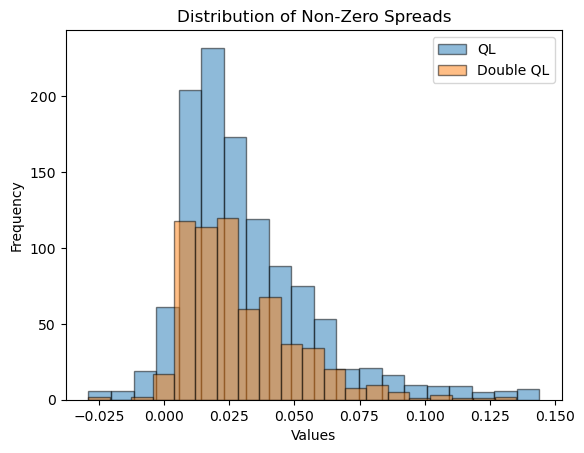

In [19]:
df_policy = pd.DataFrame(optimal_policy_QL, columns=['Policy'])
df_policy["Converted_to_Spread"] = df_policy["Policy"].map(lambda x: map_int_to_spread(x, lower_spread_limit, upper_spread_limit))

df_policy_DQL = pd.DataFrame(optimal_policy_doubleQL, columns=['Policy'])
df_policy_DQL["Converted_to_Spread"] = df_policy_DQL["Policy"].map(lambda x: map_int_to_spread(x, lower_spread_limit, upper_spread_limit))


#Save policies
df_policy.to_csv('policies/QL.csv')
df_policy_DQL.to_csv('policies/DQL.csv')


# Filter non-zero rows. OBS find a better approach where you check that this state is not visited. 
# If -0.03 really is the best spread it is now excluded
 
non_zero_rows = df_policy[~(df_policy["Converted_to_Spread"] == -0.03)]["Converted_to_Spread"]
non_zero_rows_DQL = df_policy_DQL[~(df_policy_DQL["Converted_to_Spread"] == -0.03)]["Converted_to_Spread"]

#Why do I have less bins for DQL?
# Create a histogram
plt.hist(non_zero_rows.values, bins=20, edgecolor='black', label="QL", alpha=0.5)
plt.hist(non_zero_rows_DQL.values, bins=20, edgecolor='black', label="Double QL", alpha=0.5)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Non-Zero Spreads')
plt.legend()
plt.show()